## DSC 180AB Data Science Capstone
### Replication Project

Team Members: Wenbin Jiang, AJ Falak, and Rongjing Jiang

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

This data gives insights into mental and physical health across different ages. Based on the results, people can better target groups based on their mental/physical health scores. For example, if we find there to be a high correlation between people in a specific age/demographic and their physical health, we can focus efforts on improving health decisions for these groups.
This would allow resource allocation to much more efficient. If we were to accurately predict this it could reduce wait times and help with overall efficiency.For example, healthcare utilization prediction, measuring patients requiring 10 or more medical visits, serves as a vital tool for healthcare systems worldwide, enabling providers to optimize resources regardless of their public or private framework. 



In a dataset like this, errors can have a huge real-world impact, especially in terms of resource utilization. As mentioned earlier, if we conclude that specific groups need more resources/help but find out that there were errors in the data/algorithm, then we would be incorrectly using resources that could be helping demographics that need it more.
The affected parties and stakeholders would include anyone from the healthcare sector. This would include patients, healthcare providers, insurance companies, and policymakers. For instance, patients and healthcare providers may depend on the model for identification and health assessments. It is crucial that the predictions it makes are accurate and precise.


---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [104]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


In [105]:
raw_181 = pd.read_csv('/Users/grace/Desktop/AIF360/aif360/data/raw/meps/h181.csv')

#### Apply pre-processing scripts

In [106]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [107]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [108]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [109]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [110]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [111]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

First thing is we want to check the dimensions of the dataset

In [112]:
print(df_panel_19_reduced.shape)

(15830, 43)


Also we want to view the column names

In [113]:
print(df_panel_19_reduced.columns)

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')


Get an overview of the dataset - top five

In [114]:
df_panel_19_reduced.head()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,Non-White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,Non-White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,Non-White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,Non-White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,None,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000


Get an overview of the dataset - bottom five

In [115]:
df_panel_19_reduced.tail()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16573,3,25,1,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,None,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005
16577,1,73,2,None,2,-1,4,2,2,1,...,2,42.68,43.46,0,0,4,3,2,0,6630.588948


**Descriptive Statistics**

- A helpful way to understand characteristics of the data and to get a quick summary of it.
- Provide basic statistical computations on the dataset like extreme values, count of data points, maximum value, minimum value, mean, standard deviation, etc.
- Any missing value or NaN value is automatically skipped.

In [116]:
df_panel_19_reduced.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
REGION,15830.0,NaN,NaN,NaN,2.825584,1.002033,1.0,2.0,3.0,4.0,4.0
AGE,15830.0,NaN,NaN,NaN,35.090461,22.475549,0.0,15.0,33.0,53.0,85.0
SEX,15830.0,NaN,NaN,NaN,1.521162,0.499568,1.0,1.0,2.0,2.0,2.0
RACE,5656,1,Non-White,5656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MARRY,15830.0,NaN,NaN,NaN,3.661213,2.121255,1.0,1.0,5.0,6.0,10.0
FTSTU,15830.0,NaN,NaN,NaN,-0.720088,0.910025,-1.0,-1.0,-1.0,-1.0,3.0
ACTDTY,15830.0,NaN,NaN,NaN,2.581364,0.758747,1.0,2.0,2.0,3.0,4.0
HONRDC,15830.0,NaN,NaN,NaN,2.224889,0.512242,1.0,2.0,2.0,3.0,4.0
RTHLTH,15830.0,NaN,NaN,NaN,2.187871,1.054677,-1.0,1.0,2.0,3.0,5.0
MNHLTH,15830.0,NaN,NaN,NaN,1.993051,1.002657,-1.0,1.0,2.0,3.0,5.0


In [117]:
df_panel_19_reduced.UTILIZATION.value_counts()

UTILIZATION
0    13112
1     2718
Name: count, dtype: int64

In [118]:
print(df_panel_19_reduced.nunique())

REGION             4
AGE               86
SEX                2
RACE               1
MARRY             10
FTSTU              4
ACTDTY             4
HONRDC             4
RTHLTH             6
MNHLTH             6
HIBPDX             3
CHDDX              3
ANGIDX             3
MIDX               3
OHRTDX             3
STRKDX             3
EMPHDX             3
CHBRON             3
CHOLDX             3
CANCERDX           3
DIABDX             3
JTPAIN             3
ARTHDX             3
ARTHTYPE           4
ASTHDX             2
ADHDADDX           3
PREGNT             3
WLKLIM             3
ACTLIM             3
SOCLIM             3
COGLIM             3
DFHEAR42           3
DFSEE42            3
ADSMOK42           3
PCS42           2696
MCS42           2785
K6SUM42           27
PHQ242             8
EMPST              5
POVCAT             5
INSCOV             3
UTILIZATION        2
PERWT15F       14955
dtype: int64


We are interested on attributes like `REGION`, `AGE`, `SEX`, `MARRY`, and `UTILIZATION` to better understand the data and identify any patterns or potential biases before proceeding with any modeling or analysis.

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

/var/folders/6t/wj6swww103b2jptk0dbjqj5m0000gn/T/ipykernel_52665/1386390605.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_panel_19_reduced['UTILIZATION'])


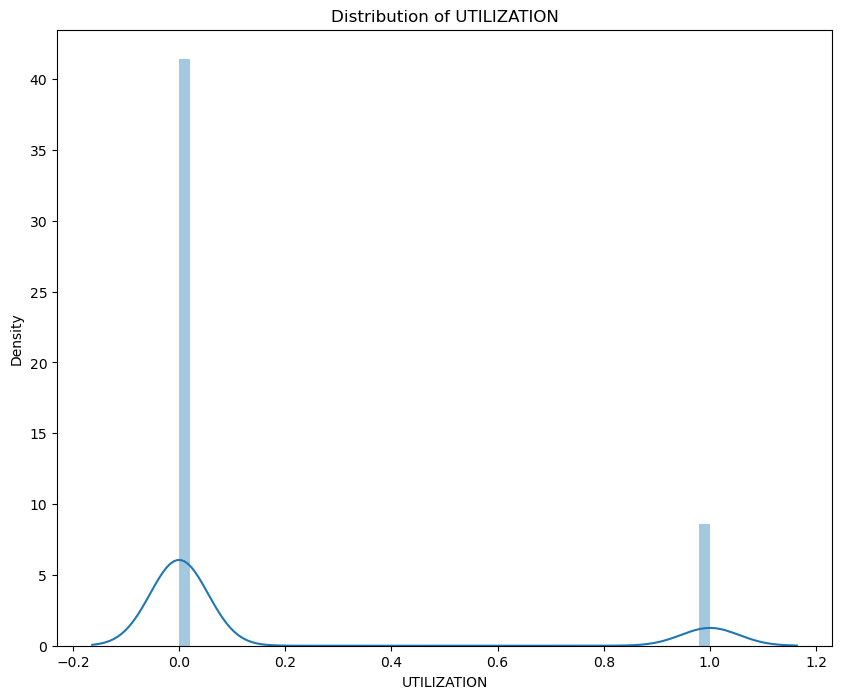

In [122]:
# Check the skewness of column 'UTILIZATION'
plt.figure(figsize= (10,8))
sns.distplot(df_panel_19_reduced['UTILIZATION'])
plt.title("Distribution of UTILIZATION")
plt.show()

### Conclusion

The above plot confirms that is highly positively skewed.

In [132]:
# Focusing on selected columns
df_panel_19_reduced = df_panel_19_reduced[['REGION', 'AGE', 'SEX', 'MARRY', 'UTILIZATION']]
print(f'Dataset contains {df_panel_19_reduced.shape[0]} rows and {df_panel_19_reduced.shape[1]} columns.')
print(df_panel_19_reduced.head())
print(df_panel_19_reduced.dtypes)

Dataset contains 15830 rows and 5 columns.
   REGION  AGE  SEX  MARRY  UTILIZATION
0       2   53    1      5            1
1       2   56    2      3            1
3       2   23    2      5            0
4       2    3    1      6            0
5       3   27    1      1            0
REGION         int64
AGE            int64
SEX            int64
MARRY          int64
UTILIZATION    int64
dtype: object


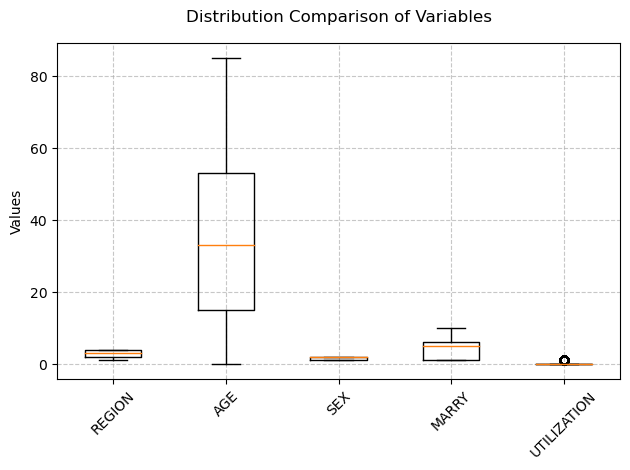

In [ ]:
# Create boxplots for all variables
variables = ['REGION', 'AGE', 'SEX', 'MARRY', 'UTILIZATION']
data = [df_panel_19_reduced[var] for var in variables]

plt.boxplot(data, labels=variables)

# Customize the plot
plt.title('Distribution Comparison of Variables', fontsize=12, pad=15)
plt.ylabel('Values')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [ ]:
#### END OF 2.2 Data shape and features ####

#### 2.3 Outlier Detection and Handling

In [123]:
df_panel_19_reduced[df_panel_19_reduced.isnull().any(axis=1)]

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
5,3,27,1,None,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000
7,3,4,1,None,6,-1,3,3,2,2,...,-1,-1.00,-1.00,-1,-1,-1,3,1,1,5724.067448
8,3,1,2,None,6,-1,3,3,2,2,...,-1,-1.00,-1.00,-1,-1,-1,3,1,0,7741.826941
9,3,45,2,None,1,-1,2,2,3,3,...,-1,-1.00,-1.00,-1,-1,1,5,1,0,10317.651664
11,3,12,1,None,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,5,1,0,10917.871269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,1,54,2,None,4,-1,2,2,4,5,...,2,37.65,25.24,13,5,4,1,2,1,2731.750793
16573,3,25,1,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16576,1,54,2,None,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005


#### 2.4 Correlation Analysis

#### 2.5 Other analysis

### [3.](#Table-of-Contents) Model Development without Debiasing 

First, load all necessary packages

In [ ]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

### 3.2. Learning a Logistic Regression (LR) classifier on original data

### 3.3. Learning a Random Forest (RF) classifier on original data

### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy: 
* Corresponding 1-min(DI, 1/DI) value: 
* Corresponding average odds difference value: 
* Corresponding statistical parity difference value: 
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

### [4.](#Table-of-Contents) Additional Model Development


### 4.1A Load data & create splits for learning/validating/testing model

In [ ]:
# Use the same methods from Section 3

### 4.3. Learning a Random Forest (RF) classifier on original data

In [ ]:
# Use the same methods from Section 3

### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy:
   * Best balanced accuracy: 
   * Corresponding 1-min(DI, 1/DI) value: 
   * Corresponding average odds difference value: 
   * Corresponding statistical parity difference value: 
   * Corresponding equal opportunity difference value:
   * Corresponding Theil index value:
    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)


### End of Replication Part 02 -  Model Development and Fairness Evaluation

----


### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion